# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import glob
import zipfile

import cv2
from PIL import Image
import albumentations as A

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.python.ops.math_ops import reduce_prod


AUTOTUNE = tf.data.experimental.AUTOTUNE

# Check GPU

In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

2.9.2
Num GPUs Available:  1


# Setting seeds

In [4]:
seed = 42

def seed_everything(seed=seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_everything()

# Download dataset

In [ ]:
# !kaggle datasets download --force -d jessicali9530/celeba-dataset

In [ ]:
# dataset = zipfile.ZipFile('celeba-dataset.zip')
# dataset.extractall('dataset')

# Paths

In [5]:
path_image_dataset = 'dataset/img_align_celeba/'
path_csv = 'dataset/list_landmarks_align_celeba.csv'
img_files = glob.glob(f'{path_image_dataset}/*/*')

# Hyperparameters and constants

In [6]:
first_image = cv2.imread(img_files[0])
default_height, default_width = first_image.shape[:2]
default_height, default_width

(218, 178)

In [7]:
target_width = 100
target_height = 100
IMG_SIZE = (target_width, target_height)
BATCH_SIZE = 64
EPOCHS = 10

# EDA

In [8]:
landmarks = pd.read_csv(path_csv)
landmarks.sample(3)


image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
93241   093242.jpg         70        108         105         112      98   
121413  121414.jpg         69        111         108         112      89   
10624   010625.jpg         70        111         108         111      92   

        nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
93241      127           77          153           104           154  
121413     129           74          152           104           152  
10624      141           73          152           103           153

In [9]:
landmarks_lips = landmarks.drop(
    columns=[
        "lefteye_x",
        "lefteye_y",
        "righteye_x",
        "righteye_y",
        "nose_x",
        "nose_y",
        "image_id",
    ],
)
landmarks_lips = landmarks_lips.rename(
    {
        "leftmouth_y": "y_min",
        "leftmouth_x": "x_min",
        "rightmouth_y": "y_max",
        "rightmouth_x": "x_max",
    },
    axis=1,
)
landmarks_lips.sample(3)

x_min  y_min  x_max  y_max
173803     75    154    102    154
70565      68    150    108    151
108725     74    152    103    152

## Images with bounding boxes

In [10]:
def view_image_from_file(file_names, xy):
    fig = plt.figure(figsize=(22, 22))
    number_of_images = len(file_names)
    for i, file in enumerate(file_names):
        img = Image.open(img_files[file])
        ax = fig.add_subplot(number_of_images // 2, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(img), (xy[i][0], xy[i][1]), (xy[i][2], xy[i][3]), (0, 255, 0), 1
        )
        ax.imshow(np.array(img, np.int32))

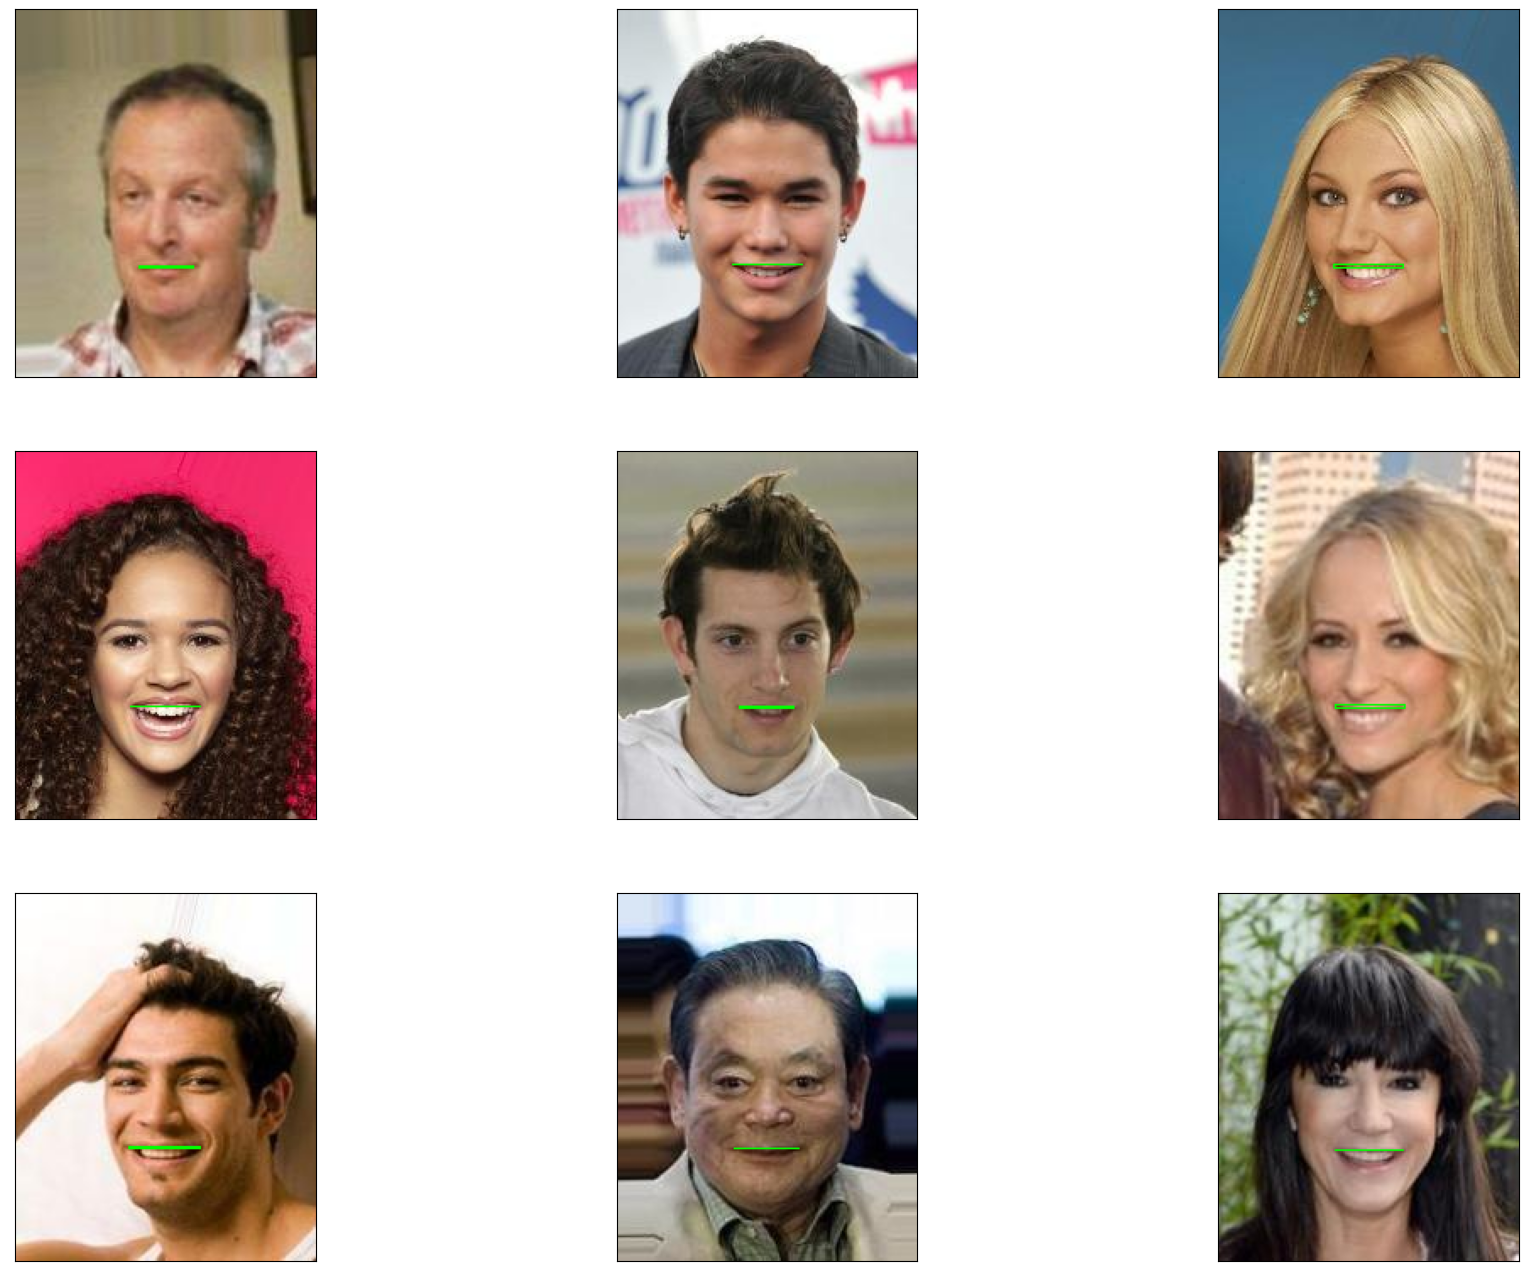

In [11]:
example_num_start = 6000
example_num_end = 6009
view_image_from_file(
    file_names=landmarks_lips.index[example_num_start:example_num_end],
    xy=landmarks_lips.values[example_num_start:example_num_end],
)

### Boundig boxes have misleading coodinates. Let's try to repair them

In [12]:
landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]

x_min  y_min  x_max  y_max
3          71    155    101    151
5          74    154    102    153
6          72    152    104    152
7          73    155    104    153
8          66    152    109    150
...       ...    ...    ...    ...
202589     73    152    104    152
202590     67    152    110    151
202593     74    153    103    151
202595     66    150    110    150
202597     71    153    106    151

[122548 rows x 4 columns]

In [13]:
landmarks_lips.loc[landmarks_lips["x_min"] >= landmarks_lips["x_max"]]

Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

In [14]:
BIAS = 10
landmarks_lips["y_min"] = landmarks["leftmouth_y"].add(-BIAS)
landmarks_lips["y_max"] = landmarks["rightmouth_y"].add(+BIAS)
landmarks_lips.head()


x_min  y_min  x_max  y_max
0     73    142    108    164
1     70    141    108    163
2     74    146     98    168
3     71    145    101    161
4     71    137    104    160

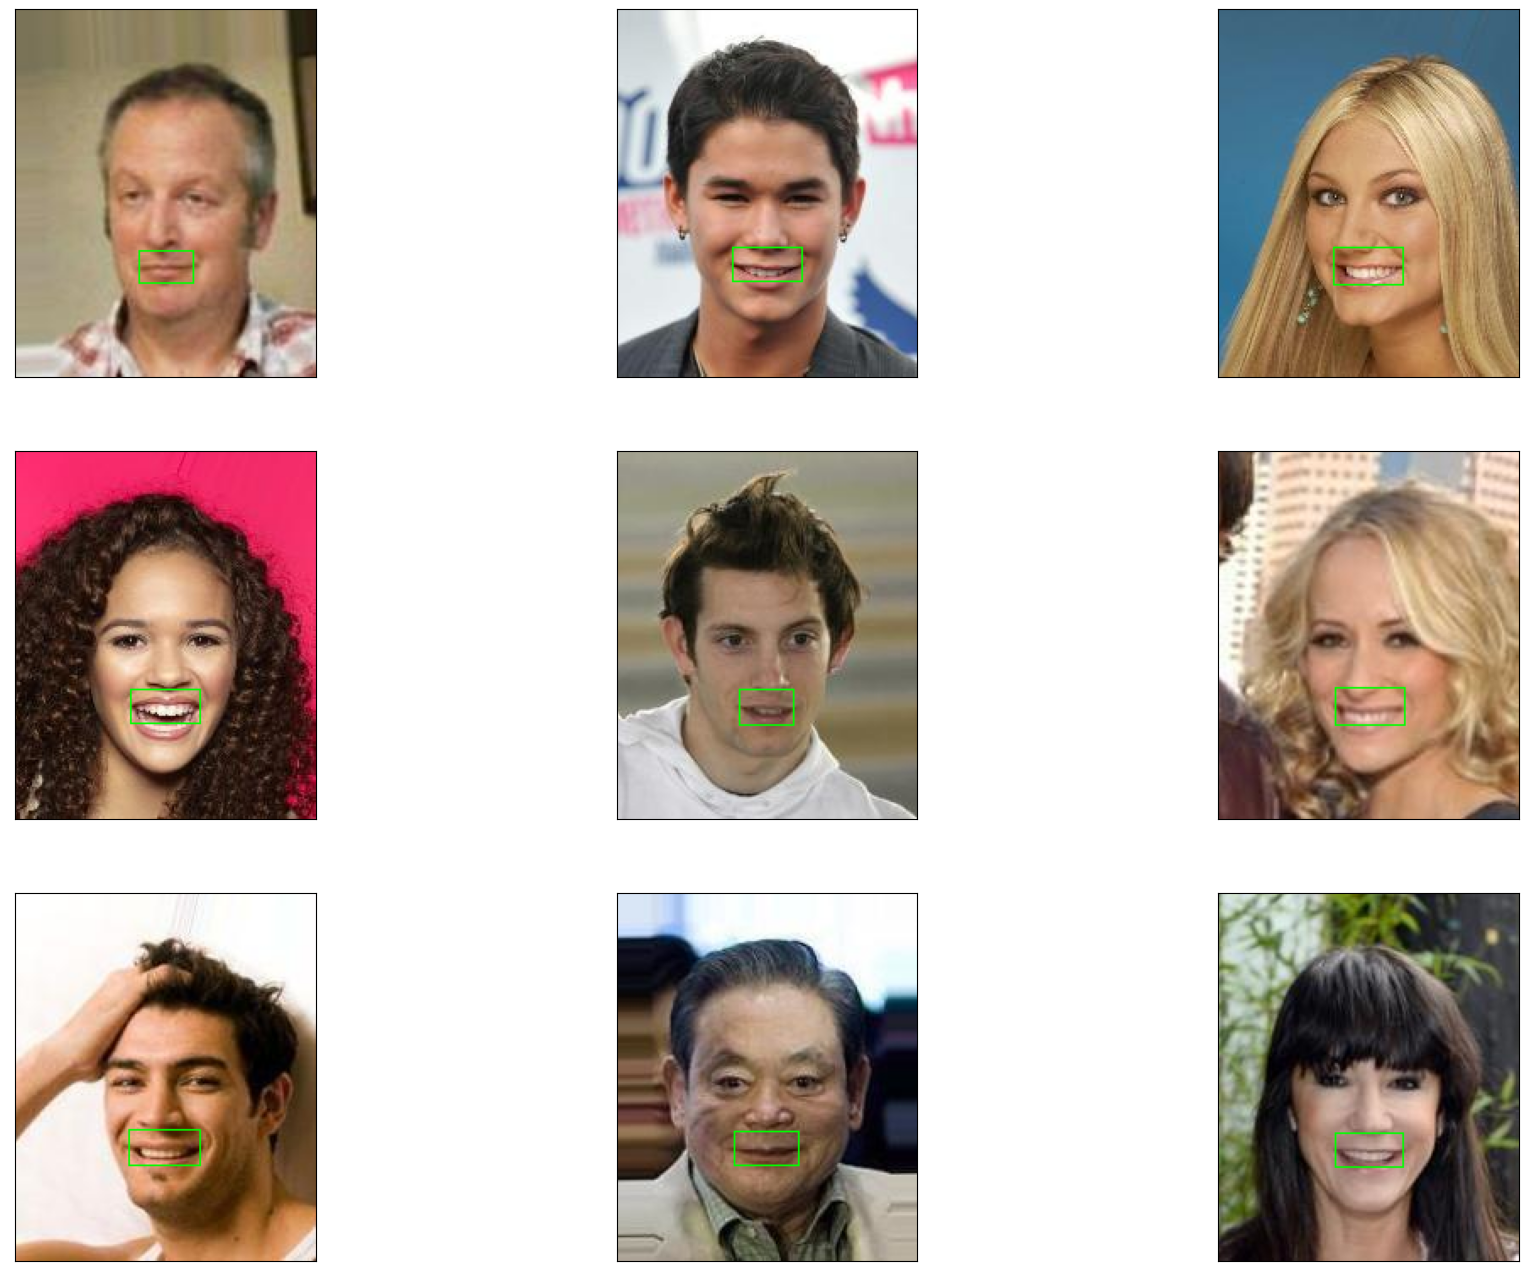

In [15]:
view_image_from_file(
    file_names=landmarks_lips.index[example_num_start:example_num_end],
    xy=landmarks_lips.values[example_num_start:example_num_end],
)

In [16]:
# We dont want to have equal values or min values to be higher than max
incorrect_values = landmarks_lips.loc[
    (landmarks_lips["y_min"] >= landmarks_lips["y_max"])
    | (landmarks_lips["x_min"] >= landmarks_lips["x_max"])
]
incorrect_values

x_min  y_min  x_max  y_max
24978      76    150     94    150
145109     64    159    104    153

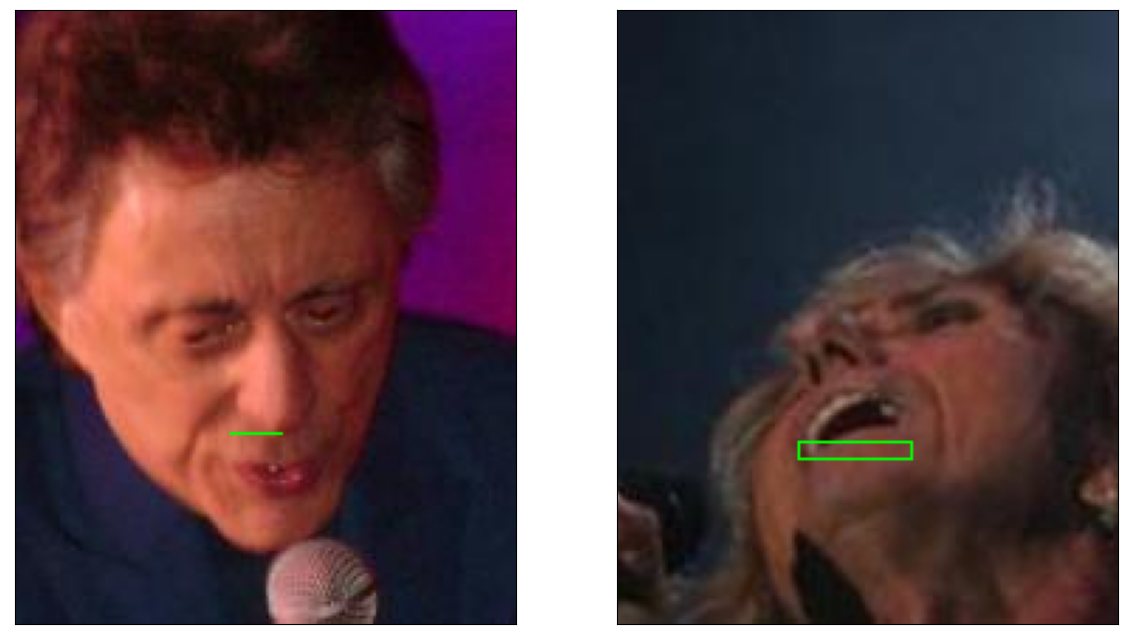

In [17]:
view_image_from_file(file_names=incorrect_values.index, xy=incorrect_values.values)

### Because we have only 2 images with wrong coordinates we can try to fix them manualy

I did some improvements by trial and error ;)


In [18]:
incorrect_values.iloc[0]["x_max"] = incorrect_values.iloc[0]["x_max"] + (15)
incorrect_values.iloc[0]["y_max"] = incorrect_values.iloc[0]["y_max"] + (20)
incorrect_values.iloc[0]["y_min"] = incorrect_values.iloc[0]["y_min"] + (5)

incorrect_values.iloc[1]["y_min"] = incorrect_values.iloc[1]["y_min"] - (30)
incorrect_values.iloc[1]["y_max"] = incorrect_values.iloc[1]["y_max"] + (10)
incorrect_values

x_min  y_min  x_max  y_max
24978      76    155    109    170
145109     64    129    104    163

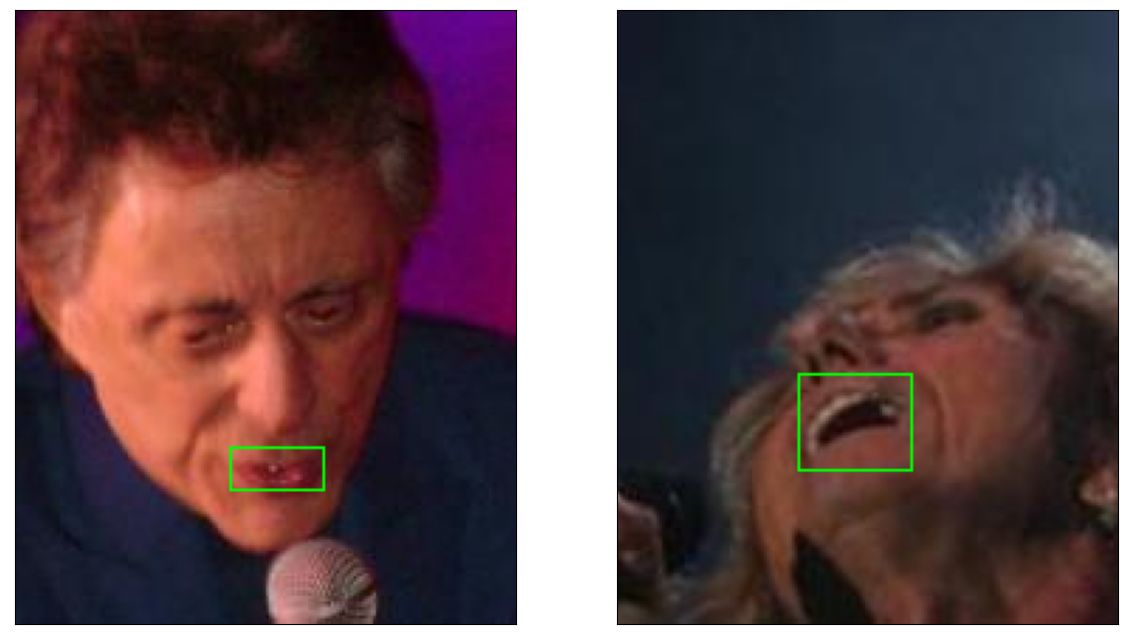

In [19]:
view_image_from_file(file_names=incorrect_values.index, xy=incorrect_values.values)

### Seems pretty good so we can do the same operations on the right DataFrame

In [20]:
landmarks_lips.iloc[incorrect_values.index[0]]["x_max"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["x_max"] + (15)
landmarks_lips.iloc[incorrect_values.index[0]]["y_max"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["y_max"] + (20)
landmarks_lips.iloc[incorrect_values.index[0]]["y_min"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["y_min"] + (5)

landmarks_lips["y_min"].iloc[incorrect_values.index[1]] = landmarks_lips["y_min"].iloc[
    incorrect_values.index[1]
] - (30)
landmarks_lips["y_max"].iloc[incorrect_values.index[1]] = landmarks_lips["y_max"].iloc[
    incorrect_values.index[1]
] + (10)

In [21]:
incorrect_values = landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]
incorrect_values

Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

### Let's do last sanity check. 24978, 145109 are ids of our incorrect images.

In [22]:
sanity_check = landmarks_lips.iloc[[24978, 145109], :]


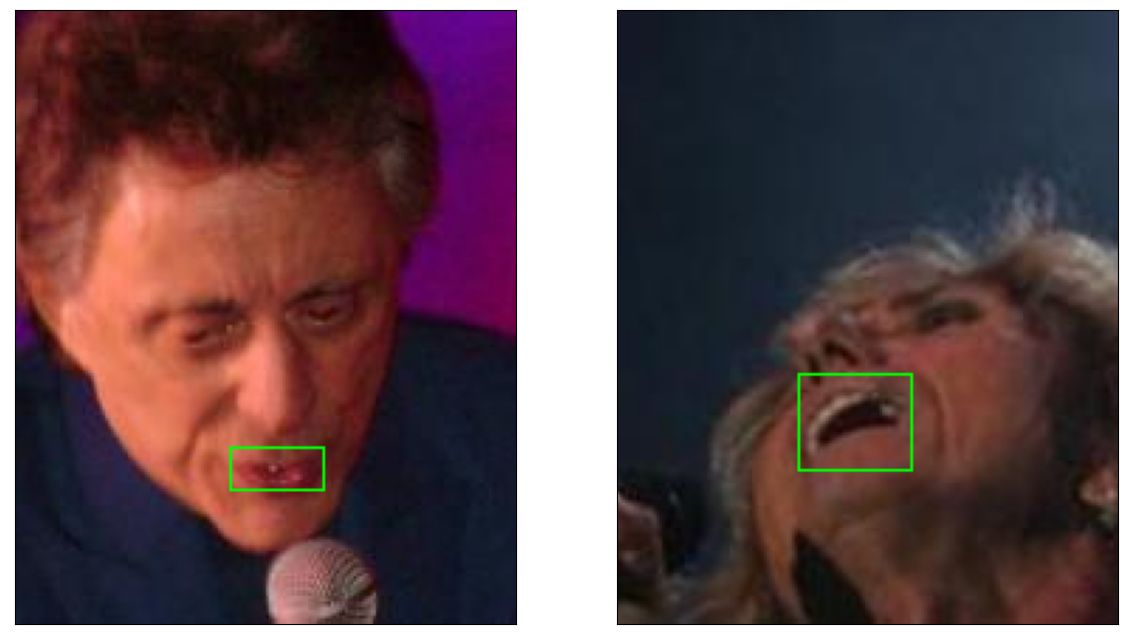

In [23]:
view_image_from_file(
    file_names=sanity_check.index, xy=sanity_check.values
)

In [24]:
landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]

Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

In [25]:
landmarks_lips


x_min  y_min  x_max  y_max
0          73    142    108    164
1          70    141    108    163
2          74    146     98    168
3          71    145    101    161
4          71    137    104    160
...       ...    ...    ...    ...
202594     73    141    104    163
202595     66    140    110    160
202596     68    141    109    163
202597     71    143    106    161
202598     75    140    103    162

[202599 rows x 4 columns]

# Normalize coordinates to 0-1 range

In [26]:
landmarks_lips_normalized = landmarks_lips[["x_min", "x_max"]].div(default_width)
landmarks_lips_normalized[["y_min", "y_max"]] = landmarks_lips[["y_min", "y_max"]].div(
    default_height
)
landmarks_lips_normalized

x_min     x_max     y_min     y_max
0       0.410112  0.606742  0.651376  0.752294
1       0.393258  0.606742  0.646789  0.747706
2       0.415730  0.550562  0.669725  0.770642
3       0.398876  0.567416  0.665138  0.738532
4       0.398876  0.584270  0.628440  0.733945
...          ...       ...       ...       ...
202594  0.410112  0.584270  0.646789  0.747706
202595  0.370787  0.617978  0.642202  0.733945
202596  0.382022  0.612360  0.646789  0.747706
202597  0.398876  0.595506  0.655963  0.738532
202598  0.421348  0.578652  0.642202  0.743119

[202599 rows x 4 columns]

## Reorganize columns order

In [27]:
cols = landmarks_lips_normalized.columns.tolist()
cols = [cols[0], cols[2], cols[1], cols[3]]
landmarks_lips_normalized = landmarks_lips_normalized[cols]

In [28]:
landmarks_lips_normalized

x_min     y_min     x_max     y_max
0       0.410112  0.651376  0.606742  0.752294
1       0.393258  0.646789  0.606742  0.747706
2       0.415730  0.669725  0.550562  0.770642
3       0.398876  0.665138  0.567416  0.738532
4       0.398876  0.628440  0.584270  0.733945
...          ...       ...       ...       ...
202594  0.410112  0.646789  0.584270  0.747706
202595  0.370787  0.642202  0.617978  0.733945
202596  0.382022  0.646789  0.612360  0.747706
202597  0.398876  0.655963  0.595506  0.738532
202598  0.421348  0.642202  0.578652  0.743119

[202599 rows x 4 columns]

In [29]:
landmarks_lips = landmarks_lips.values.tolist()
landmarks_lips_normalized = landmarks_lips_normalized.values.tolist()


# Load images from directory

In [30]:
data = tf.keras.utils.image_dataset_from_directory(
    path_image_dataset,
    batch_size=None,
    image_size=IMG_SIZE,
    labels=landmarks_lips_normalized,
    shuffle=False,
)
print(data)

Found 202599 files belonging to 1 classes.
<PrefetchDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>


In [31]:
def view_image_from_dataset(ds, number_of_samples):
    fig = plt.figure(figsize=(22, 22))
    images = ds.take(number_of_samples)
    for i, file in enumerate(images):
        ax = fig.add_subplot(number_of_samples // 2, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(file[0]),
            (int(file[1][0] * 100), int(file[1][1] * 100)),
            (int(file[1][2] * 100), int(file[1][3] * 100)),
            (0, 255, 0),
            1,
        )
        ax.set_title(
            f"boundig box:({int(file[1][0]*100)},{int(file[1][1]*100)})({int(file[1][2]*100)},{int(file[1][3]*100)})",
            fontsize=15,
        )
        ax.imshow(np.array(img, np.int32))

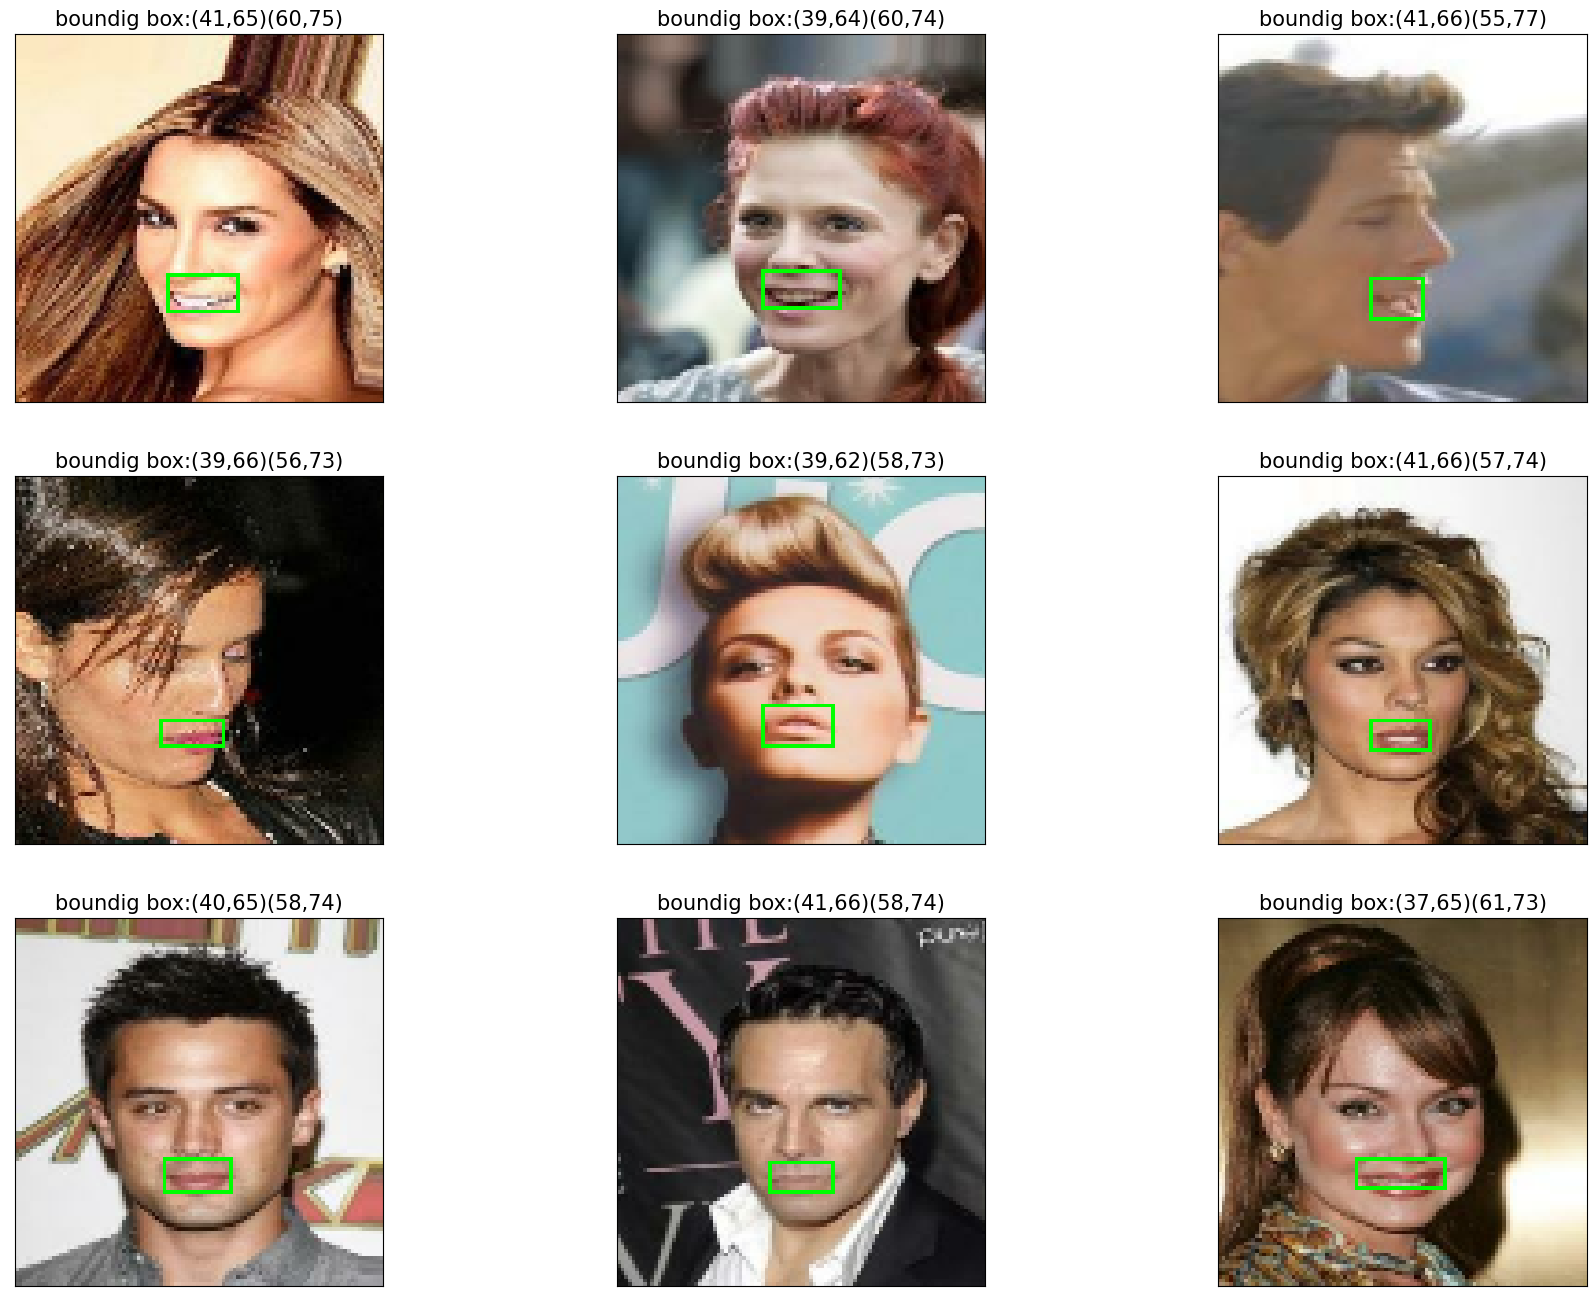

In [32]:
view_image_from_dataset(data, 9)

# Split dataset to 3 parts:
- train 80%
- validation 15% 
- test 5%

In [33]:
train_size = int(len(img_files)*0.8)
val_size = int(len(img_files)*0.15)
test_size = int(len(img_files)-(train_size+val_size))
train_size, val_size, test_size

(162079, 30389, 10131)

In [34]:
train_size+val_size+test_size, len(img_files)

(202599, 202599)

In [35]:
train = data.take(train_size)
val = data.skip(train_size)
val = val.take(val_size)
test = data.skip(train_size + val_size)

In [36]:
len(train), len(val), len(test)

(162079, 30389, 10131)

# Create augmentation and normalization functions

In [37]:
def normalization(image, label):
    image_final = tf.image.convert_image_dtype(image, tf.float32) / 255
    return image_final, label

In [38]:
class_labels = np.zeros(
    1
)  # it's only needed for albuminations - this module needs some kind of label so we will give number 0
propability = 0.5
transform = A.Compose(
    [
        A.Rotate(limit=180, p=propability),
        A.RandomBrightnessContrast(p=propability),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=propability),
        A.HueSaturationValue(
            hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=propability
        ),
        A.HorizontalFlip(p=propability),
        A.VerticalFlip(p=propability),
        A.ISONoise(p=propability),
        A.MotionBlur(p=propability),
        A.Perspective(p=propability),
        A.Affine(p=propability),
    ],
    bbox_params=A.BboxParams(
        format="albumentations", min_visibility=0.3, label_fields=["class_labels"]
    ),
)

In [39]:
def augmentation_normalization(img, label):
    transformed = transform(
        image=np.asarray(img, dtype=np.uint8),
        bboxes=[label.tolist()],
        class_labels=[class_labels],
    )
    aug_img = transformed["image"] / 255
    aug_bbox = transformed["bboxes"]

    return np.asarray(aug_img, dtype=np.float32), np.asarray(aug_bbox, dtype=np.float32)


def process_data(image, label):
    aug = tf.numpy_function(
        func=augmentation_normalization,
        inp=[image, label],
        Tout=(np.float32, np.float32),
    )
    return aug[0], aug[1]


def set_shapes(img, label):
    label.set_shape([4])
    return img, tf.squeeze(label)

# Prepare data with and without augmentation

In [40]:
train_augmented = train.map(process_data)
train_augmented = train_augmented.map(set_shapes)
train_augmented


<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [41]:
train_no_aug = train.map(normalization)
train_no_aug


<MapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [42]:
val_augmented = val.map(process_data)
val_augmented = val_augmented.map(set_shapes)
val_augmented


<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [43]:
val_no_aug = val.map(normalization)
val_no_aug


<MapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [44]:
test_augmented = test.map(process_data)
test_augmented = test_augmented.map(set_shapes)
test_augmented

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [45]:
test_no_aug = test.map(normalization)
test_no_aug


<MapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

## Take a look at augmented images

In [46]:
def view_augmented_image_from_dataset(ds, number_of_samples):
    fig = plt.figure(figsize=(22, 22))
    ds = ds.take(number_of_samples)
    for i, file in enumerate(ds):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(file[0] * 255),
            (int(file[1][0] * 100), int(file[1][1] * 100)),
            (int(file[1][2] * 100), int(file[1][3] * 100)),
            (0, 255, 0),
            1,
        )
        ax.set_title(
            f"boundig box:({int(file[1][0]*100)},{int(file[1][1]*100)})({int(file[1][2]*100)},{int(file[1][3]*100)})",
            fontsize=15,
        )
        ax.imshow(np.array(img, np.int32))

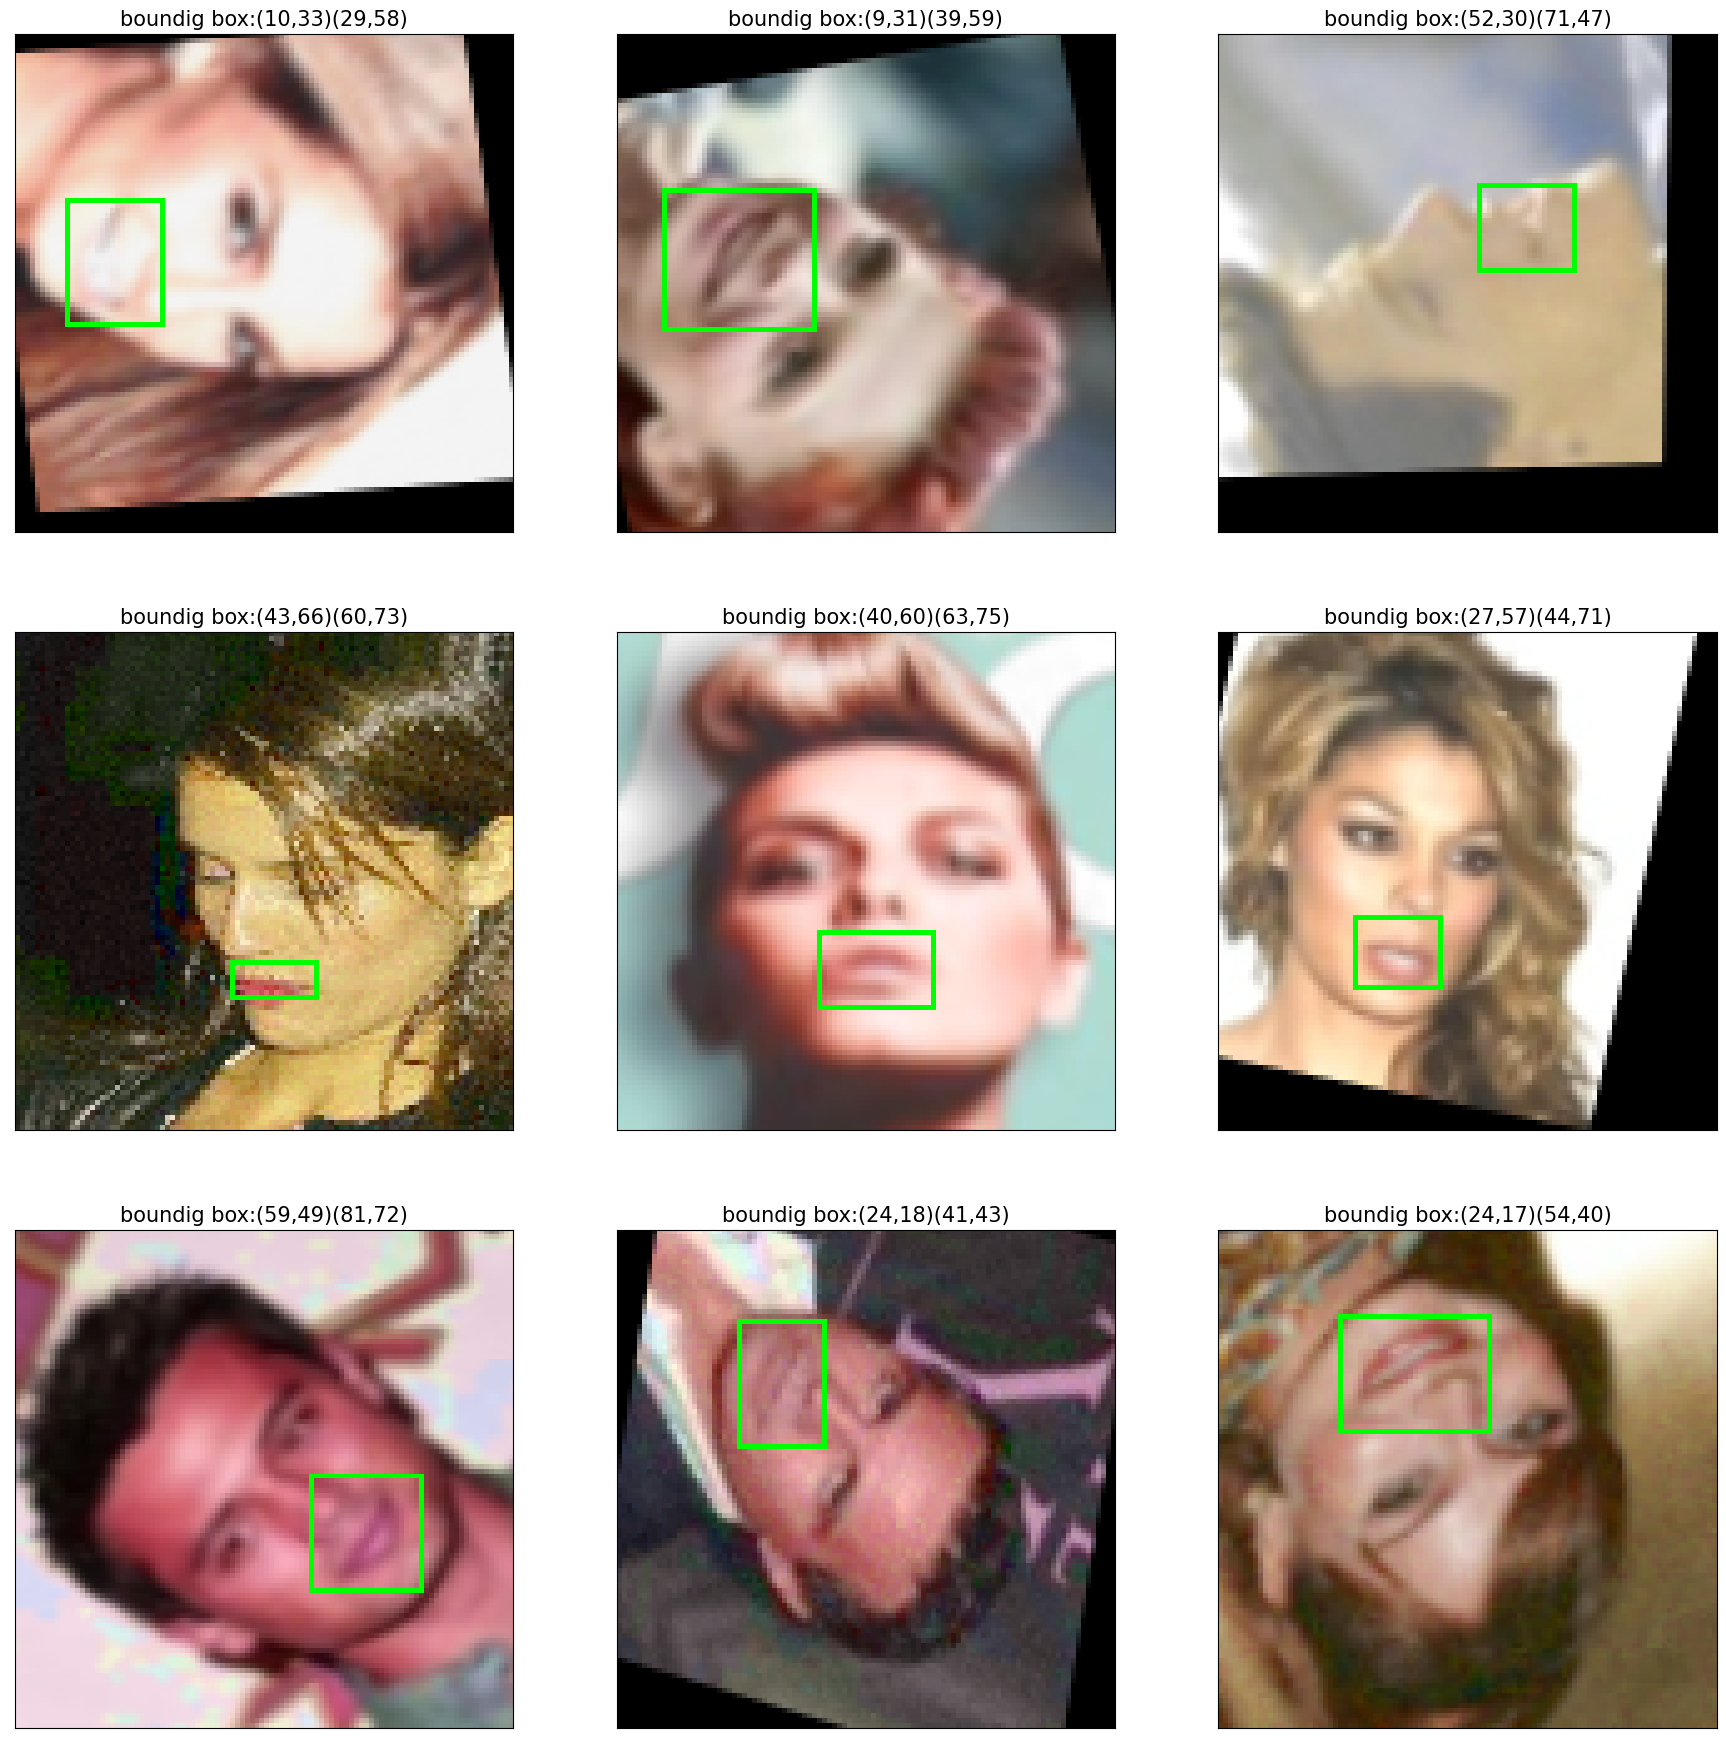

In [47]:
view_augmented_image_from_dataset(train_augmented, 9)


# Batch data

In [48]:
train_no_aug = train_no_aug.batch(BATCH_SIZE)
val_no_aug = val_no_aug.batch(BATCH_SIZE)
test_no_aug = test_no_aug.batch(BATCH_SIZE)


In [49]:
train_augmented = train_augmented.batch(BATCH_SIZE)
val_augmented = val_augmented.batch(BATCH_SIZE)
test_augmented = test_augmented.batch(BATCH_SIZE)


# Create models

## VGG16

In [ ]:
vgg = VGG16(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
)
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

my_layers = Dense(128, activation="relu")(flatten)
my_layers = Dense(64, activation="relu")(my_layers)
my_layers = Dense(32, activation="relu")(my_layers)
my_layers = Dense(4, activation="relu")(my_layers)

model_vgg16 = Model(inputs=vgg.input, outputs=my_layers)

In [ ]:
opt = Adam()
model_vgg16.compile(loss="mse", optimizer=opt)
print(model_vgg16.summary())

## My pure model

In [ ]:
model_pure = Sequential()

model_pure.add(
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_uniform",
        padding="same",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    )
)
model_pure.add(
    Conv2D(
        32, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(
    Conv2D(
        64, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(
    Conv2D(
        64, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(
    Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(
    Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(
    Conv2D(
        64, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(
    Conv2D(
        64, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_uniform",
        padding="same",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    )
)
model_pure.add(
    Conv2D(
        32, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"
    )
)
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(Flatten())
model_pure.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
model_pure.add(Dense(64, activation="relu"))
model_pure.add(Dense(32, activation="relu"))
model_pure.add(Dense(4, activation="relu"))

In [ ]:
opt = Adam()
model_pure.compile(loss="mse", optimizer=opt)
print(model_pure.summary())

## Training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

### My model

In [ ]:
model_pure.fit(train_augmented,
                   validation_data=(val_augmented),
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=1,
                   callbacks=[callback])
model_pure.save("models/model_pure_augm.h5", save_format="h5")


In [ ]:
tf.keras.backend.clear_session()
model_pure.fit(train_no_aug,
                   validation_data=(val_no_aug),
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=1,
                   callbacks=[callback])
model_pure.save("models/model_pure_no_augm.h5", save_format="h5")


### VGG16

In [ ]:
tf.keras.backend.clear_session()
model_vgg16.fit(train_augmented,
                   validation_data=(val_augmented),
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=1,
                   callbacks=[callback])
model_vgg16.save("models/model_vgg16_augm.h5", save_format="h5")

In [ ]:
tf.keras.backend.clear_session()
model_vgg16.fit(train_no_aug,
                   validation_data=(val_no_aug),
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=1,
                   callbacks=[callback])
model_vgg16.save("models/model_vgg16_no_augm.h5", save_format="h5")


# Load saved models

In [50]:
model_pure_no_augm = tf.keras.models.load_model("models/model_pure_no_augm.h5")
model_pure_augm = tf.keras.models.load_model("models/model_pure_augm.h5")
model_vgg16_no_augm = tf.keras.models.load_model("models/model_vgg16_no_augm.h5")
model_vgg16_augm = tf.keras.models.load_model("models/model_vgg16_augm.h5")

models = [model_pure_no_augm, model_pure_augm, model_vgg16_no_augm, model_vgg16_augm]
test_data = [test_no_aug, test_augmented]

models_names = [
    "model_pure_no_augm",
    "model_pure_augm",
    "model_vgg16_no_augm",
    "model_vgg16_augm",
]
test_data_names = ["test_no_aug", "test_augmented"]

# Evaluate models

In [51]:
results = []
for i, m in enumerate(models):
    for j, t in enumerate(test_data):
        print(f'model: {models_names[i]}    test_data: {test_data_names[j]}')
        results.append(
            {
                "model": models_names[i],
                "test_data": test_data_names[j],
                "loss": m.evaluate(t),
            }
        )

df = pd.DataFrame.from_records(results)
df

159/159 [==============================] - 126s 163ms/step - loss: 0.0020


model       test_data      loss
0   model_pure_no_augm     test_no_aug  0.000016
1   model_pure_no_augm  test_augmented  0.049951
2      model_pure_augm     test_no_aug  0.000115
3      model_pure_augm  test_augmented  0.000667
4  model_vgg16_no_augm     test_no_aug  0.000081
5  model_vgg16_no_augm  test_augmented  0.041351
6     model_vgg16_augm     test_no_aug  0.000372
7     model_vgg16_augm  test_augmented  0.002019

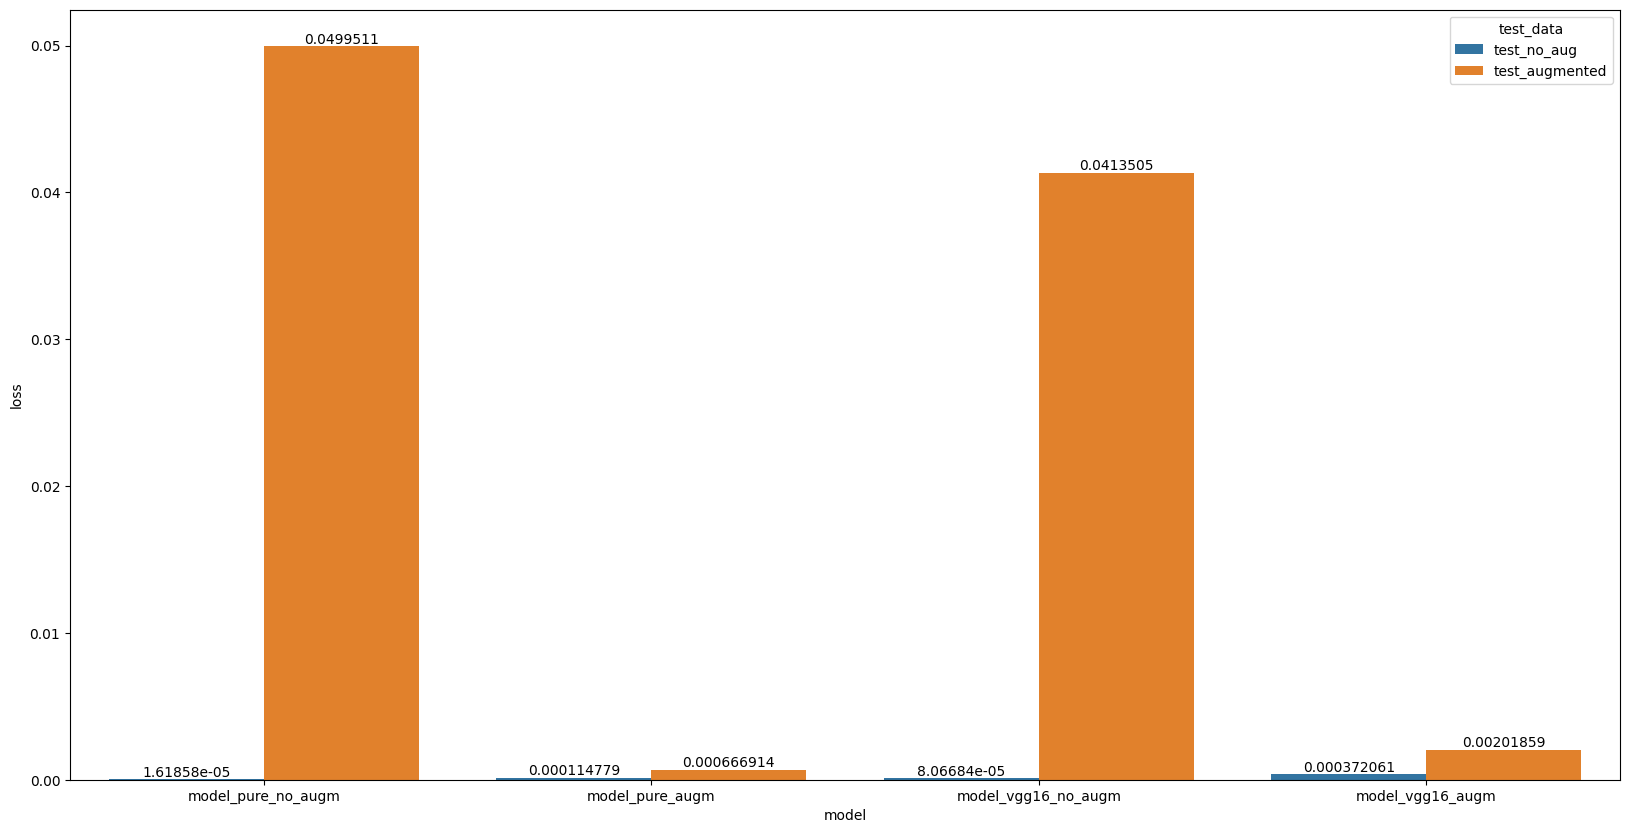

In [52]:
fig = plt.figure(figsize=(20, 10))
ax = sns.barplot(x="model", y="loss", hue="test_data", data=df)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

# Take a look at models predictions

In [53]:
def draw_bb(preds, img, color=(0, 255, 0)):
    preds = [x * 100 for x in preds]
    x_min, y_min, x_max, y_max = preds
    img_bb = cv2.rectangle(
        np.asarray(img), (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 1
    )
    return img_bb

In [54]:
image_aug, label_aug = next(iter(test_augmented))
image_no_aug, label_no_aug = next(iter(test_no_aug))


def view_test_pred(model, image, label, num_model):
    image = image.numpy()
    label = label.numpy()
    preds = model.predict(image)
    fig = plt.figure(figsize=(22, 22))

    for i in range(4):
        ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
        img = image[i]
        img = draw_bb(label[i], img, color=(0, 255, 0))
        img = draw_bb(preds[i], img, color=(255, 0, 0))
        ax.set_title(f"{models_names[num_model]}", fontsize=15)
        plt.imshow((img))

## Not augmented pure model - predictions

2/2 [==============================] - 1s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/2 [==============================] - 0s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


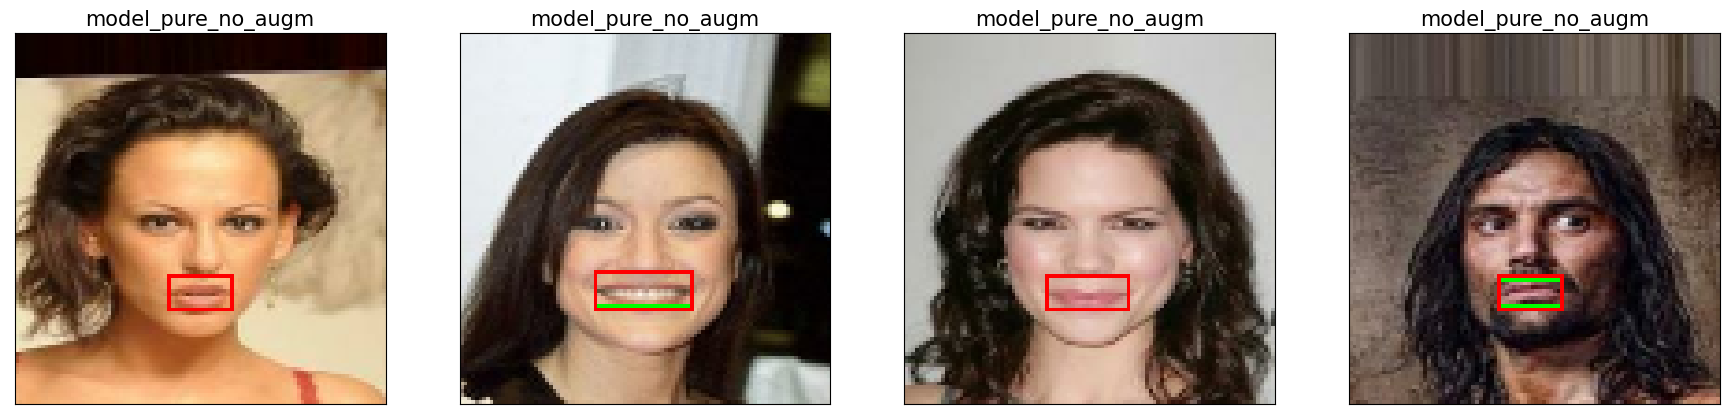

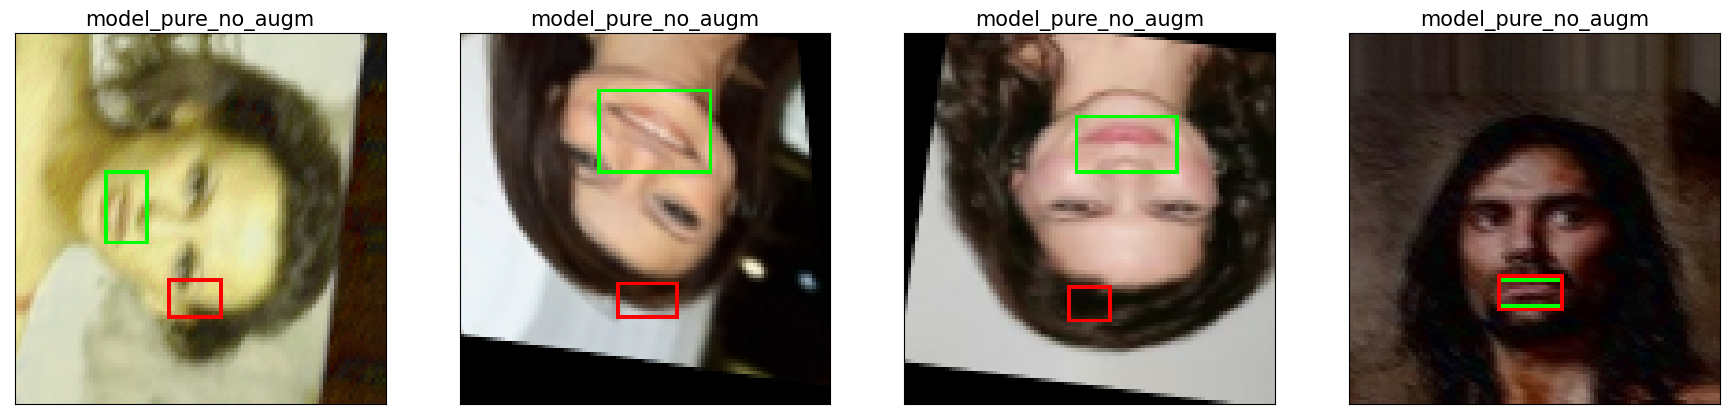

In [55]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[0], num_model = 0)
view_test_pred(image=image_aug, label=label_aug, model=models[0], num_model = 0)

## Augmented pure model - predictions

2/2 [==============================] - 0s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/2 [==============================] - 0s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


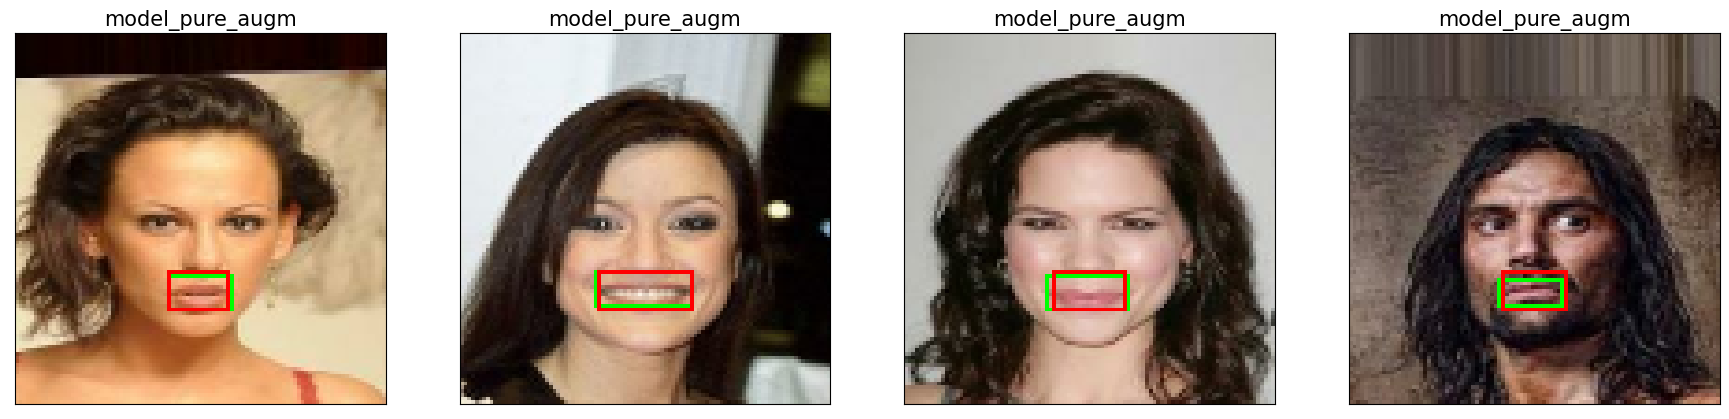

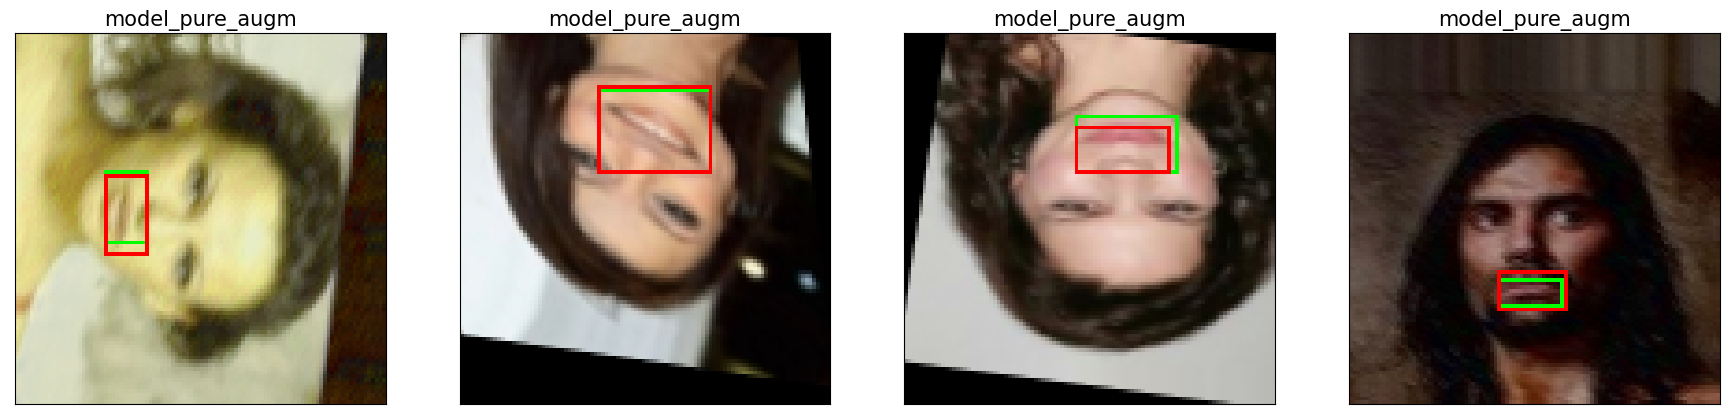

In [56]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[1], num_model = 1)
view_test_pred(image=image_aug, label=label_aug, model=models[1], num_model = 1)

## Not augmented VGG16 model - predictions

2/2 [==============================] - 0s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/2 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


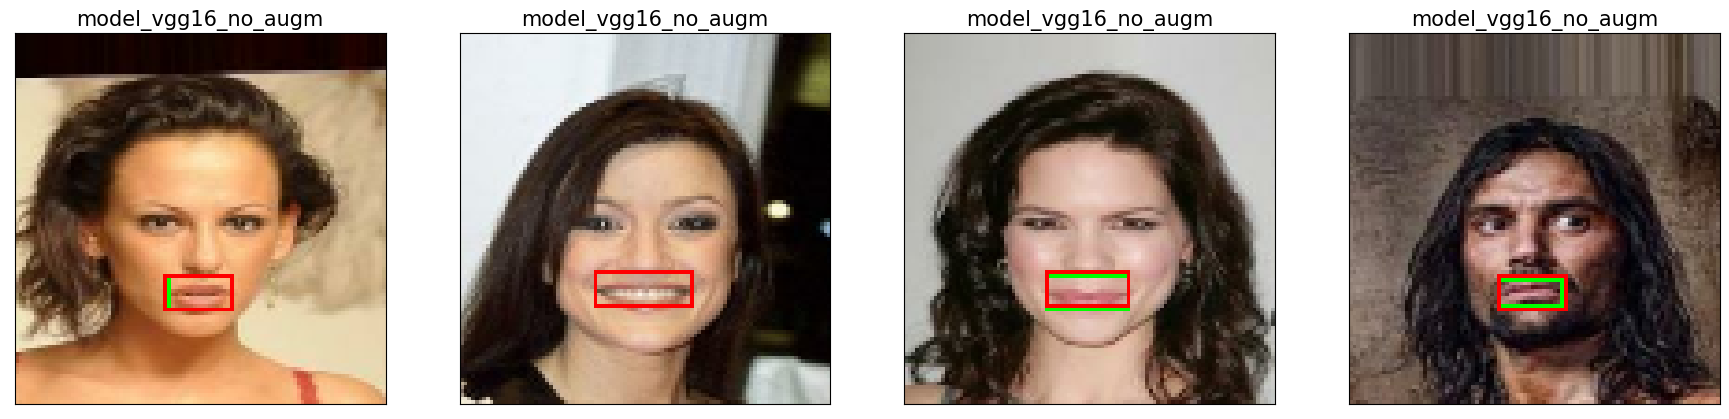

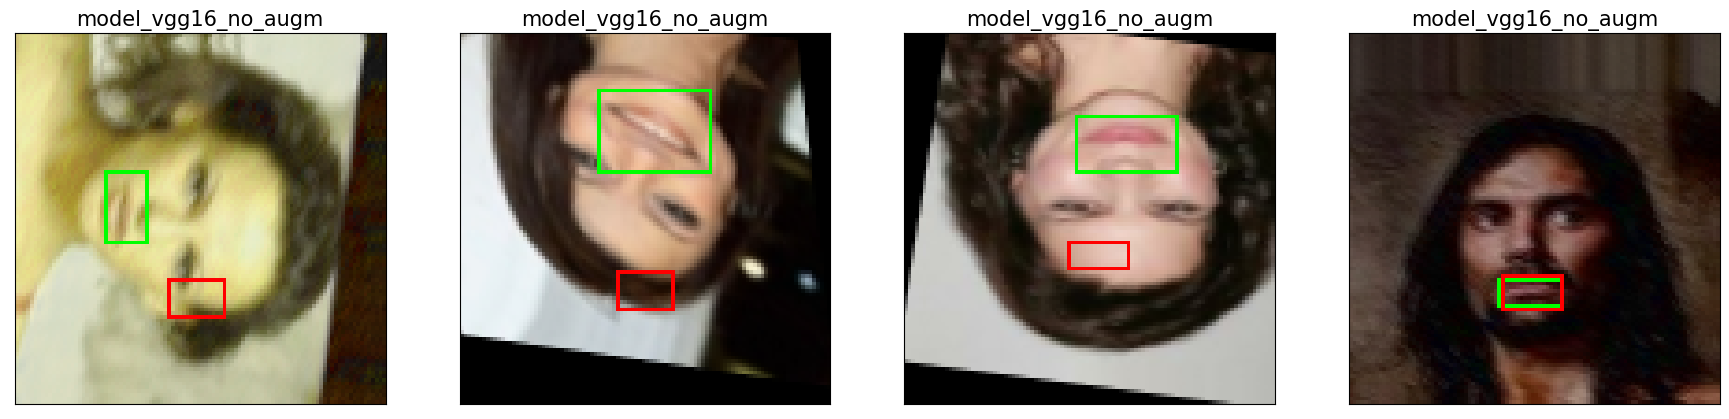

In [57]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[2], num_model = 2)
view_test_pred(image=image_aug, label=label_aug, model=models[2], num_model = 2)

## Augmented VGG16 model - predictions

2/2 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/2 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


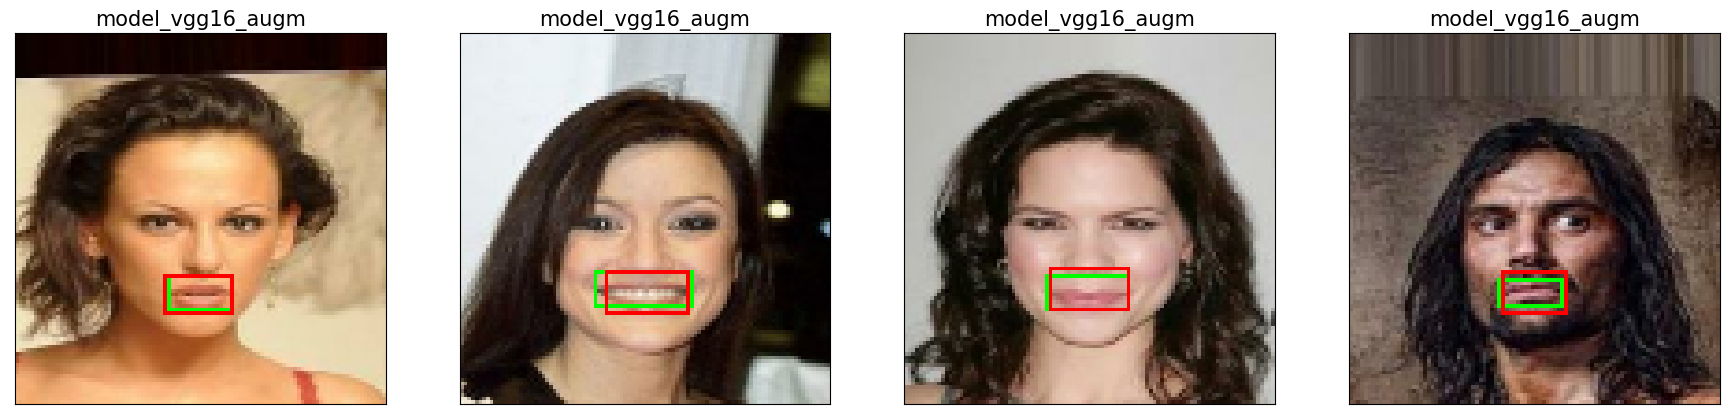

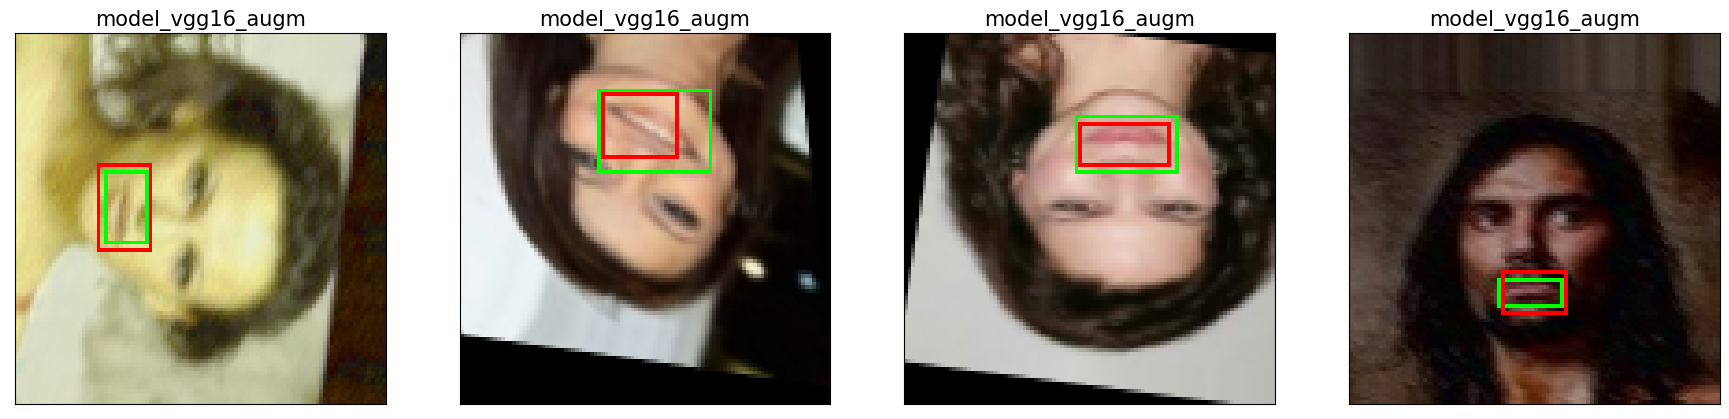

In [58]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[3], num_model = 3)
view_test_pred(image=image_aug, label=label_aug, model=models[3], num_model = 3)

# Predictions on my images

In [60]:
my_img_dir = "my_img/test/."
l = len(os.listdir(my_img_dir))
temp_bb = [-1, -1, 2, 2]
temp_bb = [temp_bb for i in range(l)]
my_images = tf.keras.utils.image_dataset_from_directory(
    "my_img",
    batch_size=64,
    image_size=(target_height, target_width),
    labels=temp_bb,
    shuffle=False,
)
print(my_images)

Found 4 files belonging to 1 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int32, name=None))>


In [61]:
my_images = my_images.map(normalization)
image, label = next(iter(my_images))


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


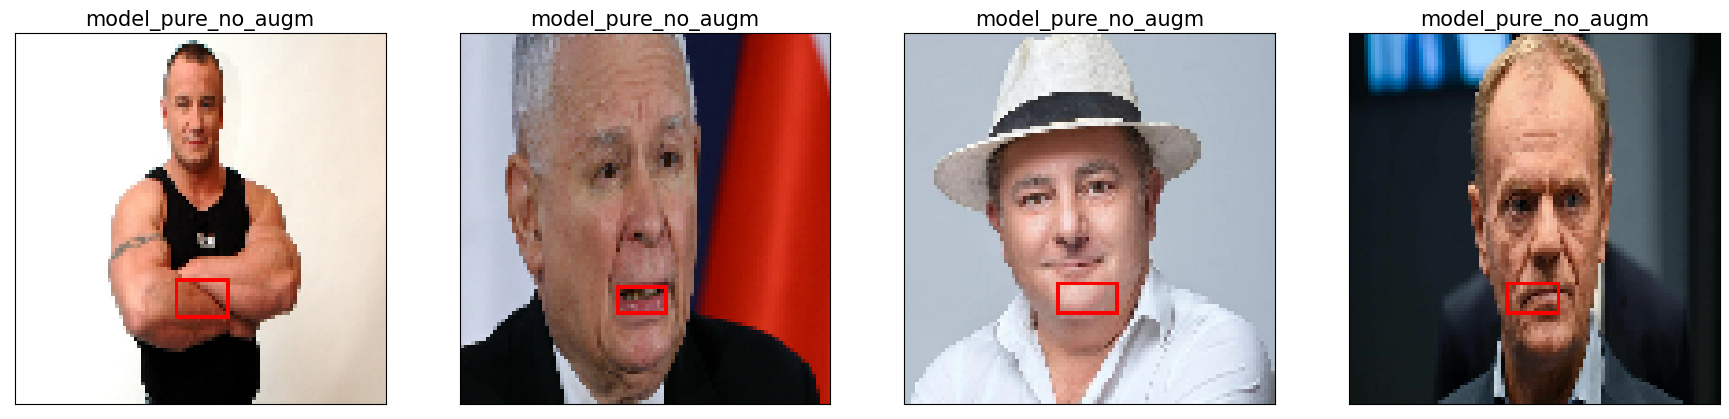

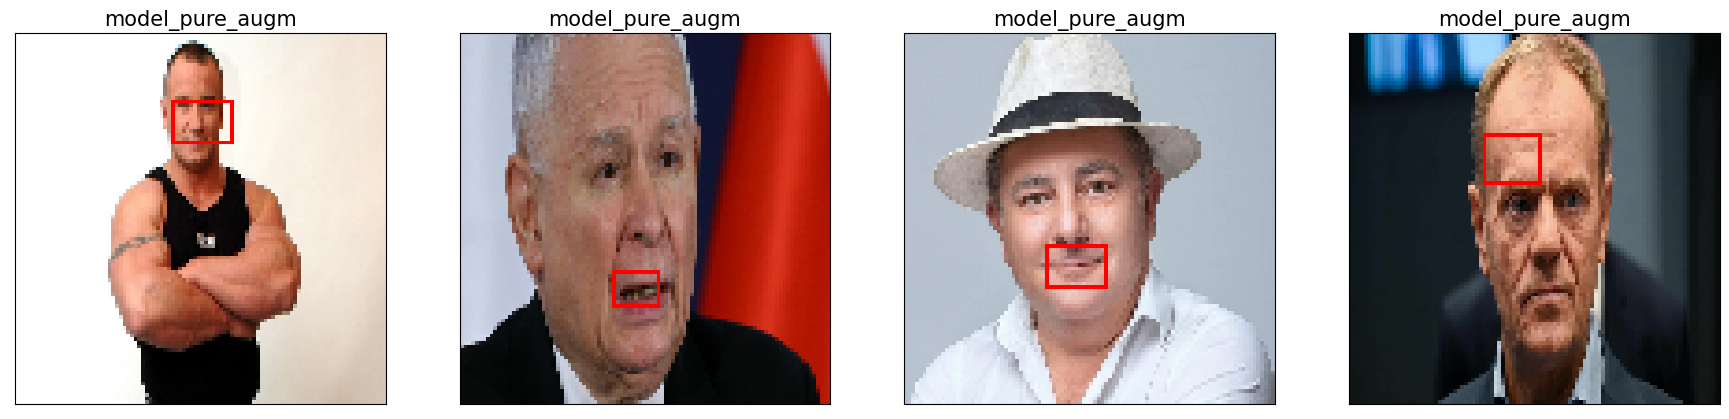

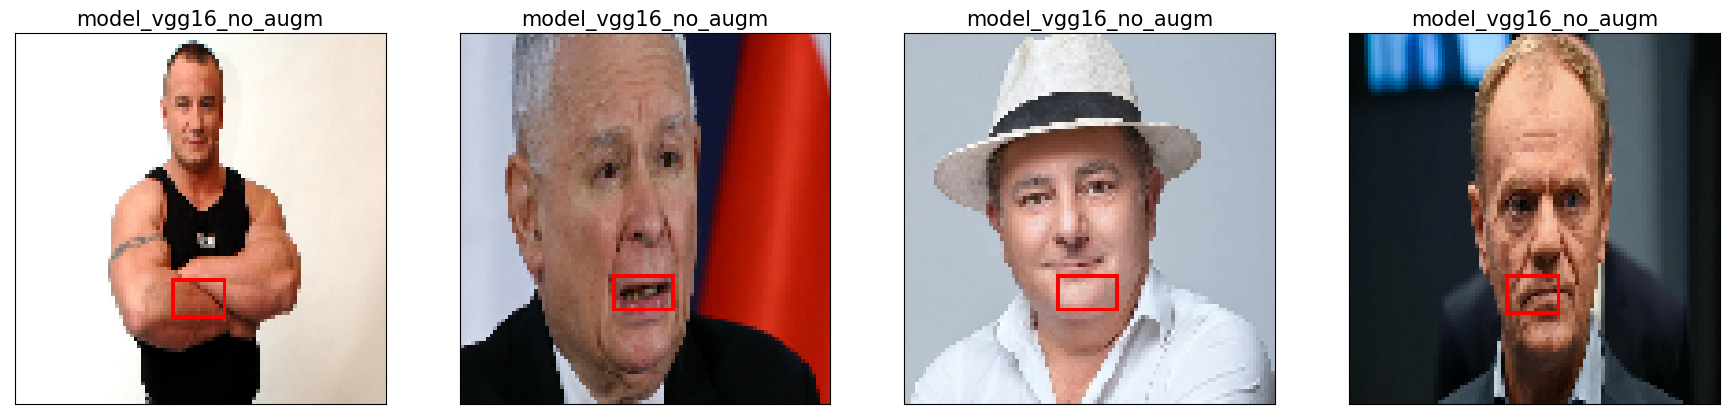

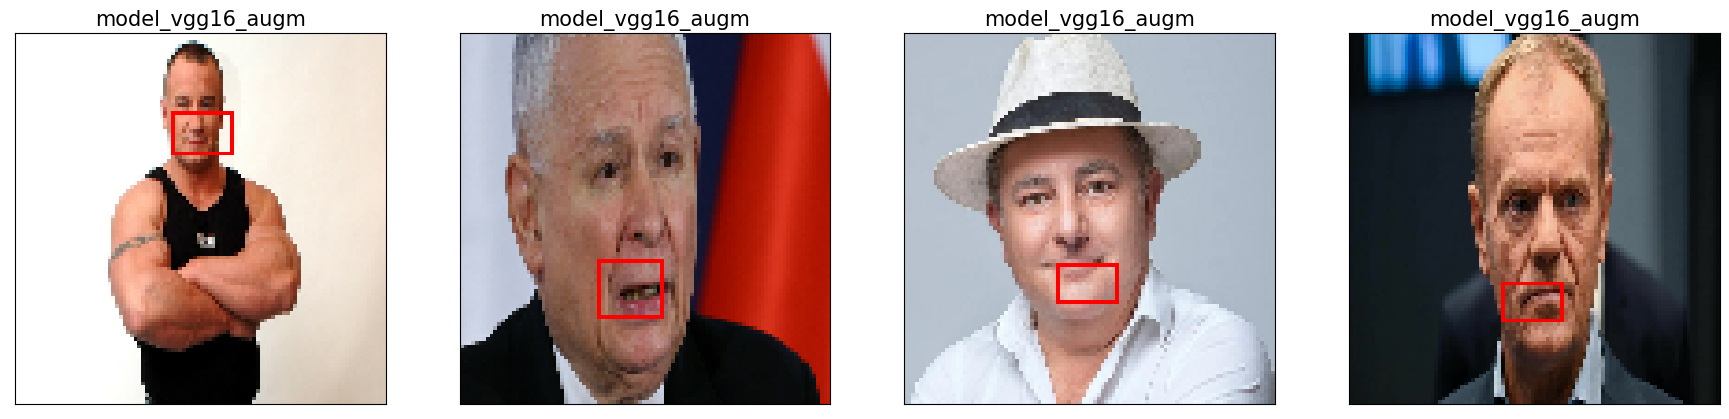

In [63]:
import warnings

warnings.filterwarnings("ignore")
for i, m in enumerate(models):
    view_test_pred(model=m, image=image, label=label, num_model=i)
